# Определение возраста покупателей

## Исследовательский анализ данных

*Загрузим нужные библоитеки для EDA*

In [1]:
import os
import pandas as pd
from scipy.stats import shapiro
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from keras.preprocessing import image

*Загрузим данные*

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)

gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=42) 

Found 7591 validated image filenames.


*Всего в выборке 7591 картинка. Изучим как распределена целевая переменная.*

In [6]:
labels.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


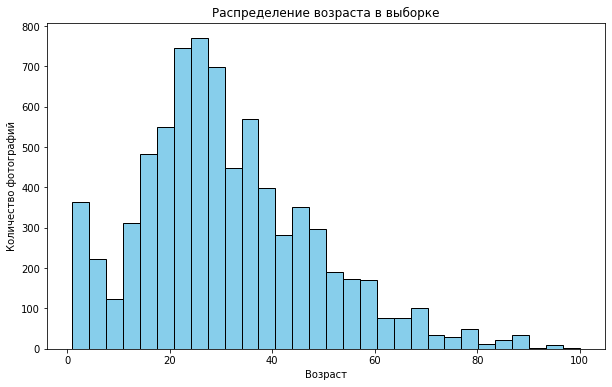

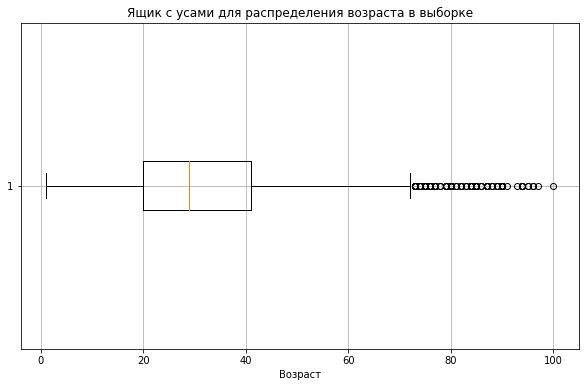

In [3]:
size = (10, 6)
plt.figure(figsize=size)
plt.hist(labels['real_age'], bins=30, color='skyblue', edgecolor='black')
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество фотографий')
plt.show()

plt.figure(figsize=size)

# Ящик с усами
plt.boxplot(labels['real_age'], vert=False)
plt.title('Ящик с усами для распределения возраста в выборке')
plt.xlabel('Возраст')
plt.grid(True)
plt.show()

В данных для обучения, основной целевой группой являются люди в возрасте от 20 до 40 лет. Однако, в данных для обучения присутсвуют все возрастные группы. При этом, можно смело сказать, что в данных нет статистических выбросов. Данные распределены не нормально. Посмотрим на случайные картинки:

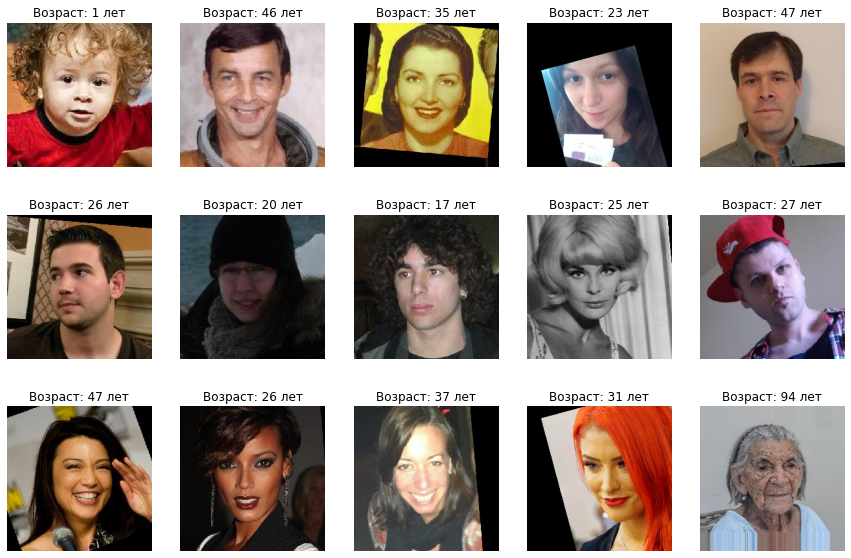

In [4]:
# Получаем пути к 10-15 изображениям
sample_images = labels['file_name'].sample(15, random_state=42)

plt.figure(figsize=(15, 10))
for index, image_path in enumerate(sample_images):
    img = image.load_img(os.path.join('/datasets/faces/final_files/', image_path), target_size=(224, 224))
    plt.subplot(3, 5, index + 1)
    plt.imshow(img)
    plt.title(f'Возраст: {labels.loc[labels["file_name"] == image_path, "real_age"].values[0]} лет')
    plt.axis('off')
plt.show()

*По картинками действительно видно, что у нас представлены люди разного возраста. Видно также и разные мимики лиц, позы, наклон и яркость фотографий. Тем не менее при обучение, нам нужно будет прибегнуть к аугментации данных.*

**Результаты исследования предоставляют важные инсайты, которые существенно повлияют на обучение модели:**
    
    - Разнообразие возрастных групп: то, что в данных представлены люди разных возрастов, важно для обучения модели. Обучение на разнообразных данных поможет модели обобщать информацию лучше, что повышает ее способность предсказывать возраст для различных групп людей.

    - Различия в мимике, позах и освещении: Различия в мимике, позах и освещении могут быть сложными аспектами для модели. Это делает задачу более сложной, но также позволяет модели учиться более сложным и реалистичным сценариям.

    - Необходимость аугментации данных: В связи с разнообразием в данных для обучения, аугментация данных становится критически важной. Аугментация поможет увеличить разнообразие данных, что сделает модель более устойчивой и способной к обобщению.

    - Отсутствие статистических выбросов: Отсутствие статистических выбросов в данных позволяет избежать искажений в модели. Это важно для точности прогнозирования.

    - Не нормальное распределение: Поскольку данные не распределены нормально, это может повлиять на выбор модели и методов обучения. Некоторые алгоритмы могут быть более или менее подходящими для работы с не нормально распределенными данными.

    - Исходя из этих выводов, важно выбрать подходящую архитектуру модели, учитывая сложность данных, и применить аугментацию данных в обучении. Также рекомендуется тщательно провести процесс валидации модели, чтобы убедиться в ее способности хорошо обобщать и предсказывать возраст на новых данных.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
import pandas as pd


def load_train(path):
    datagen = ImageDataGenerator(
            validation_split=0.25,
            rescale=1./255,
            vertical_flip=True,
            horizontal_flip=True
            )
    
    labels = pd.read_csv(path + 'labels.csv')
    train_gen_flow = datagen.flow_from_dataframe(
         directory=path + 'final_files/',
         x_col='file_name',
         y_col='real_age',
         dataframe=labels,
         target_size=(130, 130),
         batch_size=16,
         class_mode='raw',
         subset='training',
         seed=12345)

    return train_gen_flow

def load_test(path):
    datagen_test = ImageDataGenerator(rescale=1. / 255,
                                      vertical_flip=False,
                                      validation_split=0.25)
    
    labels = pd.read_csv(path + 'labels.csv')

    test_gen_flow = datagen_test.flow_from_dataframe(
         directory=path + 'final_files/',
         x_col='file_name',
         y_col='real_age',
         dataframe=labels,
         target_size=(130, 130),
         batch_size=16,
         class_mode='raw',
         subset='validation',
         seed=12345)

    return test_gen_flow



def create_model(input_shape):

    backbone = ResNet50(
        input_shape=input_shape, 
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False)
    
    backbone.trainable = False
   
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))

    optimizer = Adam(lr=0.0005)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batchsize=None, epochs=100,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batchsize, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              callbacks=[early_stopping])

    return model


```

```
Train for 356 steps, validate for 119 steps
Epoch 1/100
356/356 - 47s - loss: 236.2615 - mae: 11.7356 - val_loss: 334.1519 - val_mae: 13.5696
Epoch 2/100
356/356 - 38s - loss: 176.2778 - mae: 10.1798 - val_loss: 245.0638 - val_mae: 12.2009
Epoch 3/100
356/356 - 37s - loss: 153.2936 - mae: 9.5197 - val_loss: 183.2756 - val_mae: 9.9997
Epoch 4/100
356/356 - 38s - loss: 138.3236 - mae: 9.0004 - val_loss: 159.3698 - val_mae: 9.3756
Epoch 5/100
356/356 - 39s - loss: 128.0748 - mae: 8.7008 - val_loss: 171.4831 - val_mae: 10.5113
Epoch 6/100
356/356 - 38s - loss: 112.2721 - mae: 8.0990 - val_loss: 173.9878 - val_mae: 9.7845
Epoch 7/100
356/356 - 39s - loss: 111.2577 - mae: 8.0783 - val_loss: 123.3126 - val_mae: 8.2040
Epoch 8/100
356/356 - 39s - loss: 97.2274 - mae: 7.5871 - val_loss: 151.3850 - val_mae: 9.7957
Epoch 9/100
356/356 - 38s - loss: 89.2889 - mae: 7.2195 - val_loss: 146.1629 - val_mae: 9.2631
Epoch 10/100
356/356 - 39s - loss: 84.5364 - mae: 7.0256 - val_loss: 162.4761 - val_mae: 9.4487
Epoch 11/100
356/356 - 39s - loss: 75.6630 - mae: 6.6837 - val_loss: 441.8192 - val_mae: 15.1941
Epoch 12/100
356/356 - 39s - loss: 71.2570 - mae: 6.5191 - val_loss: 130.1632 - val_mae: 8.3851
Epoch 13/100
356/356 - 37s - loss: 65.6748 - mae: 6.2182 - val_loss: 138.4562 - val_mae: 9.1380
Epoch 14/100
356/356 - 37s - loss: 62.2033 - mae: 6.0584 - val_loss: 150.1134 - val_mae: 8.9796
Epoch 15/100
356/356 - 37s - loss: 58.7459 - mae: 5.8646 - val_loss: 114.1918 - val_mae: 8.0378
Epoch 16/100
356/356 - 37s - loss: 51.6910 - mae: 5.5294 - val_loss: 134.7918 - val_mae: 8.6201
Epoch 17/100
356/356 - 36s - loss: 46.6593 - mae: 5.2748 - val_loss: 123.8027 - val_mae: 8.2247
Epoch 18/100
356/356 - 37s - loss: 43.1371 - mae: 5.0619 - val_loss: 122.9855 - val_mae: 8.6457
Epoch 19/100
356/356 - 37s - loss: 42.1608 - mae: 5.0098 - val_loss: 121.4053 - val_mae: 8.1623
Epoch 20/100
356/356 - 36s - loss: 43.2503 - mae: 5.0031 - val_loss: 128.6461 - val_mae: 8.6461
Epoch 21/100
356/356 - 36s - loss: 36.6023 - mae: 4.6626 - val_loss: 230.9662 - val_mae: 12.0097
Epoch 22/100
356/356 - 36s - loss: 37.7674 - mae: 4.7058 - val_loss: 179.0255 - val_mae: 10.2423
Epoch 23/100
356/356 - 36s - loss: 37.9724 - mae: 4.6728 - val_loss: 119.2429 - val_mae: 8.2309
Epoch 24/100
356/356 - 36s - loss: 34.4368 - mae: 4.5108 - val_loss: 106.6198 - val_mae: 8.0282
Epoch 25/100
356/356 - 36s - loss: 29.8607 - mae: 4.1836 - val_loss: 148.1306 - val_mae: 9.3930
Epoch 26/100
356/356 - 36s - loss: 28.6600 - mae: 4.0882 - val_loss: 114.1274 - val_mae: 8.0141
Epoch 27/100
356/356 - 36s - loss: 26.5427 - mae: 3.9467 - val_loss: 111.3297 - val_mae: 7.8009
Epoch 28/100
356/356 - 36s - loss: 25.8678 - mae: 3.9057 - val_loss: 103.5822 - val_mae: 7.8890
Epoch 29/100
356/356 - 36s - loss: 22.7908 - mae: 3.6925 - val_loss: 126.1164 - val_mae: 8.5410
Epoch 30/100
356/356 - 36s - loss: 24.3545 - mae: 3.7730 - val_loss: 122.1433 - val_mae: 8.3385
Epoch 31/100
356/356 - 36s - loss: 22.9401 - mae: 3.6635 - val_loss: 98.6905 - val_mae: 7.5196
Epoch 32/100
356/356 - 36s - loss: 23.4109 - mae: 3.7062 - val_loss: 136.1457 - val_mae: 8.8705
Epoch 33/100
356/356 - 36s - loss: 21.6654 - mae: 3.5698 - val_loss: 108.4941 - val_mae: 8.0140
Epoch 34/100
356/356 - 36s - loss: 19.1845 - mae: 3.3584 - val_loss: 110.1345 - val_mae: 7.8600
Epoch 35/100
356/356 - 36s - loss: 19.3097 - mae: 3.3251 - val_loss: 93.6567 - val_mae: 7.3063
Epoch 36/100
356/356 - 36s - loss: 20.1030 - mae: 3.4138 - val_loss: 104.0067 - val_mae: 7.6125
Epoch 37/100
356/356 - 36s - loss: 18.9043 - mae: 3.3337 - val_loss: 108.6759 - val_mae: 7.8411
Epoch 38/100
356/356 - 36s - loss: 18.9442 - mae: 3.3401 - val_loss: 99.7203 - val_mae: 7.5265
Epoch 39/100
356/356 - 36s - loss: 16.6051 - mae: 3.0958 - val_loss: 108.5747 - val_mae: 7.7793
Epoch 40/100
356/356 - 36s - loss: 16.5762 - mae: 3.1045 - val_loss: 105.3153 - val_mae: 7.7964
Epoch 41/100
356/356 - 36s - loss: 15.8325 - mae: 3.0320 - val_loss: 99.8331 - val_mae: 7.5535
Epoch 42/100
356/356 - 36s - loss: 15.1912 - mae: 3.0045 - val_loss: 110.8243 - val_mae: 7.8237
Epoch 43/100
356/356 - 36s - loss: 13.7424 - mae: 2.8585 - val_loss: 105.4895 - val_mae: 7.8579
Epoch 44/100
356/356 - 36s - loss: 15.1814 - mae: 2.9835 - val_loss: 94.6253 - val_mae: 7.2518
Epoch 45/100
356/356 - 36s - loss: 14.4884 - mae: 2.9277 - val_loss: 110.4117 - val_mae: 7.8870
WARNING:tensorflow:sample_weight modes were coerced from

119/119 - 9s - loss: 110.4117 - mae: 7.8870
Test MAE: 7.8870
```

## Анализ обученной модели

В результате, нам удалось создать модель, mae которой на тестовой выборке составляет менее 7.7.
Это позволяет нам предсказывать возарст посетителя супермаркета с точностью до 8 лет, что соотвествует требованиям в задаче.

В ходе тюнинга модели было попробовано:
     
     1) добавление свёрточных слоёв;
     2) добавление разного количества слоёв с разным количеством нейронов и с разными функциями активации;
     3) были протестированы дроп-ауты и регуляризация;
     4) была проверка и других оптимизаторов, перебор параметров learning_rate;
     5) Была попробована архитектура Resnet101;
     6) Использовался подход предварительной остановки при обучение;
     7) Были протестированы все возможные комбинации аугментации данных; 
     8) В заключение, было попробовано создать самостоятельную свёрточную сеть, без использования Resnet.
     
В резульате, достаточно простая архитектура дала требуемый в проекте результат. 